<a href="https://colab.research.google.com/github/lcipolina/Ray/blob/main/2_Ray_Tune_FeedFWD_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to add Ray Tuner to a Feed Forward in Pytorch

### Resources on Feed Forwards
https://medium.com/mlearning-ai/training-feed-forward-neural-network-ffnn-on-gpu-beginners-guide-2d04254deca9

https://medium.com/analytics-vidhya/pytorch-for-deep-learning-feed-forward-neural-network-d24f5870c18

https://towardsdatascience.com/a-simple-starter-guide-to-build-a-neural-network-3c2cf07b8d7c

### Resources on Ray Tune
https://medium.com/riselab/cutting-edge-hyperparameter-tuning-with-ray-tune-be6c0447afdf

https://github.com/anyscale/academy/tree/main/ray-tune

https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

https://docs.ray.io/en/master/tune/user-guide.html

https://huggingface.co/blog/ray-tune


In [2]:
import cv2
from google.colab.patches import cv2_imshow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import sklearn

### Feed Forwards Big Picture

The five steps in the life-cycle are as follows:

    1. Prepare the Data.
    2. Define the Model.
    3. Train the Model.
    4. Evaluate the Model.
    5. Make Predictions

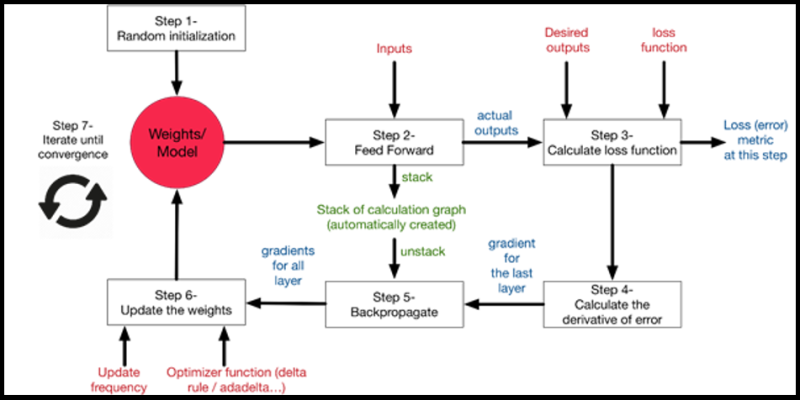

In [3]:
!curl -sS https://i.imgur.com/03jtoSi.png > kp.jpg 
img= cv2.imread("kp.jpg")
img= cv2.resize(img, (800,400), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

## Data


In [4]:
#importing the 'diabetes' dataset
from sklearn.datasets import load_diabetes
data = load_diabetes()
x = data['data']
y = data['target']
#shape
print('shape of x is : ',x.shape)
print('shape of y is : ',y.shape)

shape of x is :  (442, 10)
shape of y is :  (442,)


#### Data set and Data Loaders
  - Convert data to tensor
  - Return dimensions

In [5]:
#dataset
from torch.utils.data import Dataset, DataLoader
class diabetesdataset(Dataset):
  def __init__(self,x,y):   # Inherited from the parent class nn.Module
 
    self.x = torch.tensor(x).float() #transform to tensor 
    self.y = torch.tensor(y).float()


    self.length = self.x.shape[0]  

  def __getitem__(self,idx):
      return self.x[idx],self.y[idx]  

  def __len__(self):
      return self.length

dataset = diabetesdataset(x,y)

In [6]:
# Split into Training and Validation datasets
from torch.utils.data import random_split
torch.manual_seed(43)
val_size = 100 #change according to data shape (number of rows)

train_size       = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(342, 100)

DataLoader is used to perform mini batch or stochastic gradient descent by acting as an iterable

We use DataLoader class to shuffle data and separate it into batches that are feed to neural networks during each training step.

In [7]:
#dataloader 

batch_size = 100 #batch size is a hyperparameter

def load_data(train_ds, val_ds,batch_size):
    train_loader = DataLoader(train_ds, batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size*2, shuffle=False)
    #test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True) #we have no test data for now

    return train_loader, val_loader

## Defining the Network
In PyTorch, neural networks are created by using Object Oriented Programming. 

The layers are defined in the init function and the forward pass is defined in the forward function, which is invoked automatically when the class is called.

These Functions are possible because of the class nn.Module from torch which was inherited.

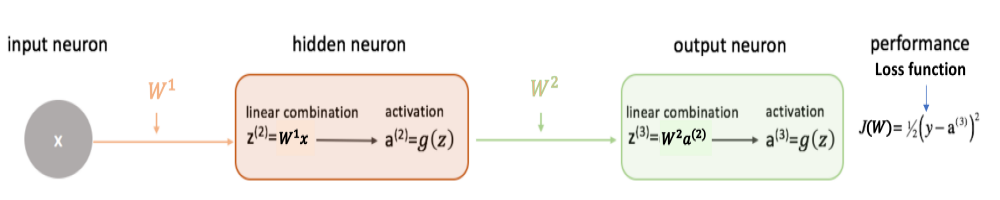

In [8]:
# Forward Propagation
!curl -sS https://i.imgur.com/E9IT9IH.png > kp.jpg 
img= cv2.imread("kp.jpg")
img= cv2.resize(img, (1000,200), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

In [9]:
# Creating the network
from torch import nn

class Net(nn.Module):
  def __init__(self,input_size,hidden_nodes,output_size):  
    super(Net,self).__init__()                        # Inherited from the parent class nn.Module
    self.l1   = nn.Linear(input_size,hidden_nodes)    # 1st Full-Connected Layer: (input data) -> (hidden node)
    self.relu = nn.ReLU()                             # Non-Linear ReLU Layer: max(0,x)
    self.l2   = nn.Linear(hidden_nodes,output_size)   # 2nd Full-Connected Layer: (hidden node) -> 1 (output class)
    
  # Get predictions  
  def forward(self,x):                              # Forward pass: stacking each layer together
    output = self.l1(x) 
    output = self.relu(output)
    output = self.l2(output)
    return output

### Defining the Loss and Hyperparameters

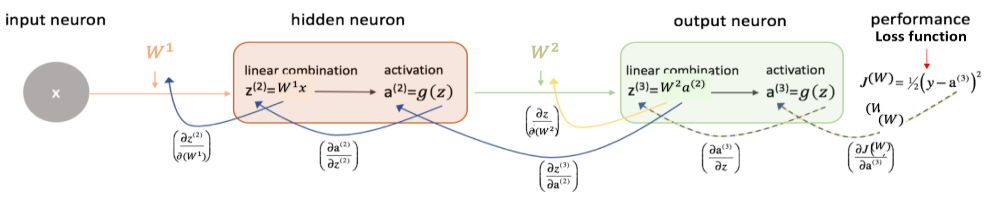

In [10]:
# Back Propagation
!curl -sS https://i.imgur.com/h0L2ier.png > kp.jpg 
img= cv2.imread("kp.jpg")
img= cv2.resize(img, (1000,200), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

## Training

In [11]:
def train(model, loss_fn, optimizer,device, data = None):
  
    model.train()                                          # Sets model on training model (updates gradients)

    for xb,yb in data:                                     #Load a batch 
        x_train, y_train = xb.to(device),  yb.to(device)   # GPU         

        y_pred = model(x_train)                            # Forward pass: compute the output class given the features (calls the 'forward' method of the Class)

        y_pred = y_pred.reshape(-1)                        #make sizes match (old pytorch)

        #calculating loss
        loss = loss_fn(y_pred,y_train)                     # Compute the loss: difference between the output class and the pre-given label
        

        #backprop
        optimizer.zero_grad()                              # Intialize the hidden weight to all zeros
        loss.backward()                                    # Backward pass: compute the weight
        optimizer.step()                                   # Optimizer: update the weights of hidden nodes

  #Not needed with Ray
  #if j%5 == 0:  #prints every 5 epochs                     # Logging               
  #  print(cost)
  #  costval.append(loss)
    #%(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]


### Validation

In [12]:
def valid(model,loss_fn, device,data = None):    
        
    #### Runs this for every epoc ####        
    sum_batch_valid_loss = 0.0 #running loss
        
    model.eval() #set model to Evaluation mode
    with torch.no_grad():        
        for xb,yb in data:                  #Load a batch 
            x, y = xb.to(device),  yb.to(device)   #GPU        
            pred = model(x) 

            pred = pred.reshape(-1) #make sizes match (old pytorch)
            valid_step_loss = loss_fn(pred, y)

            sum_batch_valid_loss += valid_step_loss.item()*xb.size(0)
    
    return sum_batch_valid_loss

In [13]:
# Hyperparameters
hidden_size = 5

In [14]:
#input size = number of features , output size = 1 (one predicted value)
input_dim = x.shape[1]
output_dim = 1
print(input_dim)

10


### Model Specification and Train Wrapper

In [20]:
def trainFF(config,data = None):
   
    train_loader, val_loader = data
    
    #Model Configuration *************************************************************
    # Instatiate the class
    net = Net(input_dim, hidden_size, output_dim)

    # Enable GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count()>1:
        net = nn.DataParallel(net) 
    net.to(device)

    # Loss Function and Optimizer
    criterion = nn.MSELoss()  #Mean Squared Loss because this is a regression problem
    
    
    # **** LR Decay (without momentum) *****
    optimizer = torch.optim.SGD(net.parameters(),lr=config["lr"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9) #Multiplies the learning rate with gamma every step_size (i.e.epochs). 
    #*****

  
    # **************************************************************************************
    #Run model for multiple epochs    
   
    for epoch in range(1,config['num_epochs']+1): 
    
        #print()
        #print('Epoch: {0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr'])) #track the epoch we are computing
        
        train(net, criterion, optimizer, device, data = train_loader)
        sum_batch_valid_loss = valid(net, criterion, device, data = val_loader)      
        
        avg_valid_loss       = sum_batch_valid_loss/val_size        
             
        scheduler.step()   #Optimize LR Based on Epochs
        
        # Send the current training result back to Tune
        tune.report(loss = float(avg_valid_loss))

    
    #Save last checkpoint and close connection
    with tune.checkpoint_dir(epoch) as directory:
         print('Checkpoint DIRECTORY:',directory)
         path = os.path.join(directory,"checkpoint")
         torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_valid_loss,
             }, path)

    tune.report(avg_valid_loss = float(avg_valid_loss), done=True)  
 
    return 

## Run the model with Ray Tune

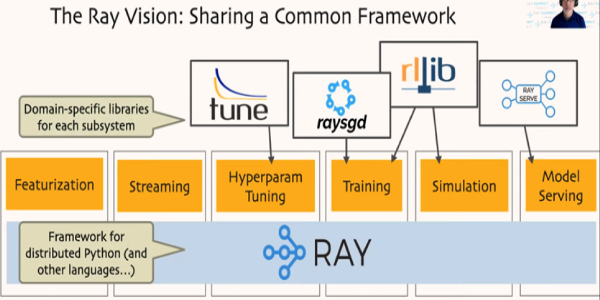

In [29]:
!curl -sS https://i.imgur.com/vRjge8N.png > kp.jpg 
img= cv2.imread("kp.jpg")
img= cv2.resize(img, (600,300), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

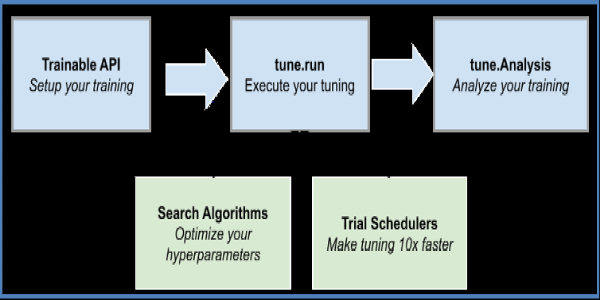

In [30]:
!curl -sS https://i.imgur.com/K8l1tgu.png > kp.jpg 
img= cv2.imread("kp.jpg")
img= cv2.resize(img, (600,300), interpolation = cv2.INTER_AREA)
cv2_imshow(img)

In [ ]:
!pip install ray[default] # -> Install here, otherwise it breakes the environment
!pip install ray torch torchvision
!pip install ray[tune]

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.progress_reporter import JupyterNotebookReporter

Trainer

In [21]:
import os
os.environ["RAY_PICKLE_VERBOSE_DEBUG"] = "1"


config_dic= {
    "lr": tune.grid_search([ 0.1, 0.01]),  
    "num_epochs": 2,
    "batch_size": batch_size
}

#For the LR we can also use:
# config={"lr": tune.uniform(lower, upper)} # between 1e-5 and 1e-1
#config={"lr": tune.uniform(lower, upper)}, metric="loss", mode="min", search_alg=BayesOptSearch()

    
data = load_data(train_ds, val_ds,config_dic['batch_size'])

#Initialize service and pass the number of resources available
ray.init(num_cpus = 1,
         num_gpus = 0,
         ignore_reinit_error = True)


analysis = tune.run(
            tune.with_parameters(trainFF, data = data),          
            config = config_dic,
            verbose = 2,
            progress_reporter=JupyterNotebookReporter(overwrite=False),
            resources_per_trial={"cpu": 1, "gpu": 0} #how many resources for each trial, it can be set to: gpu:0.5 for efficiency.
            )
            

2021-08-11 16:08:53,999	INFO worker.py:811 -- Calling ray.init() again after it has already been called.


Trial trainFF_6cc16_00000 reported loss=171332.625 with parameters={'lr': 0.1, 'num_epochs': 2, 'batch_size': 100}.
(pid=389) Checkpoint DIRECTORY: /root/ray_results/trainFF_2021-08-11_16-08-54/trainFF_6cc16_00000_0_lr=0.1_2021-08-11_16-08-54/checkpoint_000002
Trial trainFF_6cc16_00000 reported avg_valid_loss=33478.96484375,should_checkpoint=True with parameters={'lr': 0.1, 'num_epochs': 2, 'batch_size': 100}. This trial completed.
Trial trainFF_6cc16_00001 reported loss=27821.91015625 with parameters={'lr': 0.01, 'num_epochs': 2, 'batch_size': 100}.
Trial trainFF_6cc16_00001 reported avg_valid_loss=24603.8046875,should_checkpoint=True with parameters={'lr': 0.01, 'num_epochs': 2, 'batch_size': 100}. This trial completed.


Trial name,status,loc,lr,iter,total time (s),avg_valid_loss
trainFF_6cc16_00000,TERMINATED,,0.1,3,0.0524011,33479
trainFF_6cc16_00001,TERMINATED,,0.01,3,0.0489953,24603.8


2021-08-11 16:08:59,080	INFO tune.py:550 -- Total run time: 5.07 seconds (4.93 seconds for the tuning loop).


(pid=415) Checkpoint DIRECTORY: /root/ray_results/trainFF_2021-08-11_16-08-54/trainFF_6cc16_00001_1_lr=0.01_2021-08-11_16-08-55/checkpoint_000002


## Analyze Results

Get best configuration

In [ ]:
variable_trailed = "loss" #this should be a string
bestconfig = analysis.get_best_config(metric = variable_trailed, mode="min")
print("Best config: ", bestconfig)

Convert 'analysis' into a DataFrame

In [ ]:
type(analysis)  #initially it is not a DataFrame

In [ ]:
df = analysis.results_df
df.keys() 
#note how the loss is a column name

In [ ]:
#Let's explore what we have available
df

In [ ]:
vble_trailed = loss #this is a column name

# Get a dataframe for analyzing trial results.
df = analysis.results_df

#Plot the performance of this trial
dfs = analysis.fetch_trial_dataframes()
[d.loss.plot() for d in dfs.values()]    #we have used the column name
plt.xlabel("epoch"); plt.ylabel("Valid Loss"); 

## Load the Saved Model

In [ ]:
torch.save(model.state_dict(), ‘fnn_model.pkl’)